normal operation
1st-order contingencies
0
1
2
3
4
5
6
7
8
9
10
11


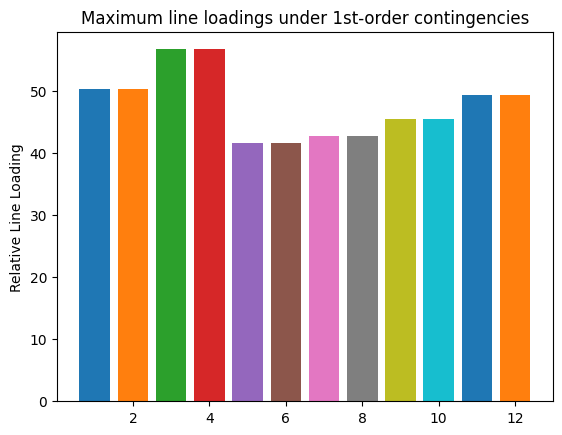

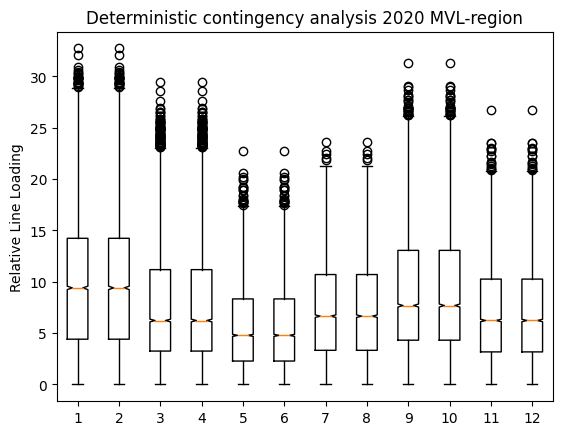

AttributeError: 'DataFrame' object has no attribute 'append'

In [8]:
# state_enumeration_MVL - Bart Tuinema
# Performs deterministic (n-1) contingency analysis
# using and generation/load data for a complete year (2020)
# MVL region only (MVL region load flow)
import numpy as np
from get_B_matrix import get_B_matrix_NL_func2020_MVL_without_SMH
from get_P_lines import get_P_lines_MVL_func
import matplotlib.pyplot as plt
import pandas as pd

# Output DF with columns Perror, Poverload, Pislanded
output_df = pd.DataFrame(columns=['Windgen', 'order', 'Perror', 'Poverload', 'Pislanded'])

for w in np.linspace(0,5.5,12):
    extra_offshore_wind = w ##offshore wind to be added (in GW)

    ## Line capacities

    C_lines = [2650, 2650, 2632.7, 2632.7, 2909.9, 2909.9, 2632.7, 2632.7, 2909.9, 2909.9, 2632.7, 2632.7]


    ## state enumeration: initial values

    P_lines_normal = np.zeros([12,8736])     # circuit loadings in normal operation (for one year)
    P_lines_max_cont = np.zeros([12,1])      # maximum circuit loadings in deterministic n-1 contingency analysis

    ## EXERCISE 3 & 4 VARIABLES
    unavailabilities = np.array([2.46e-3, 2.46e-3, 2.01e-5, 2.01e-5, 6.18e-3, 6.18e-3, 3.58e-5, 3.58e-5, 1.33e-4, 1.33e-4, 2.93e-5, 2.93e-5])
    availabilities = np.ones(12) - unavailabilities
    #print(unavailabilities[2]*np.prod(availabilities))
    P_error = 1
    P_overload = 0
    P_islanded = 0
    P_redispatch = 0
    E_redispatch = 0

    ## contingency analysis: bus loads (substation loads)
    df = pd.read_csv('scenario2020_MVL.csv') # these are the generation and load (in MW) per substation
    MVL380_load = np.matrix(df['MVL380_load'].values.tolist())
    SMH380_load = np.matrix(df['SMH380_load'].values.tolist())
    WL380W_load = np.matrix(df['WL380W_load'].values.tolist())
    WL380Z_load = np.matrix(df['WL380Z_load'].values.tolist())
    WTR380_load = np.matrix(df['WTR380_load'].values.tolist())
    BWK380_load = np.matrix(df['BWK380_load'].values.tolist())
    CST380_load = np.matrix(df['CST380_load'].values.tolist())
    KIJ380_load = np.matrix(df['KIJ380_load'].values.tolist())
    MVL380_gen = np.matrix(df['MVL380_gen'].values.tolist())
    SMH380_gen = np.matrix(df['SMH380_gen'].values.tolist())
    MVL380_exp = np.matrix(df['MVL380_exp'].values.tolist())
    MVL380_wind = np.matrix(df['MVL380_wind'].values.tolist())

    df = pd.read_csv('scenario2020_line_flows_MVL.csv') # these are the line flows (in MW) to the rest of the 380kV network
    VHZ380_BWK380a = np.matrix(df['VHZ380_BWK380a'].values.tolist())
    VHZ380_BWK380b = np.matrix(df['VHZ380_BWK380b'].values.tolist())
    BKL380_KIJ380 = np.matrix(df['BKL380_KIJ380'].values.tolist())
    KIJ380_GT380a = np.matrix(df['KIJ380_GT380a'].values.tolist())
    KIJ380_GT380b = np.matrix(df['KIJ380_GT380b'].values.tolist())
    KIJ380_OZN380 = np.matrix(df['KIJ380_OZN380'].values.tolist())

    bus_loads = np.zeros([8736,6])
    bus_loads[:,0] = MVL380_load + SMH380_load   # the loads are added to the buses (i.e. substations)
    bus_loads[:,1] = WL380W_load + WL380Z_load
    bus_loads[:,2] = WTR380_load
    bus_loads[:,3] = BWK380_load
    bus_loads[:,4] = CST380_load
    bus_loads[:,5] = KIJ380_load
    bus_loads[:,0] = bus_loads[:,0] + MVL380_gen + SMH380_gen   # the generation of MVL and SMH are added to bus 1 (MVL)
    bus_loads[:,0] = bus_loads[:,0] + MVL380_exp   # the export to the UK is added to MVL
    bus_loads[:,3] = bus_loads[:,3] - VHZ380_BWK380a - VHZ380_BWK380b   # at bus 4 (BWK), the line loadings to the rest of the 380kV network (VHZ) are added
    bus_loads[:,5] = bus_loads[:,5] - BKL380_KIJ380 + KIJ380_GT380a + KIJ380_GT380b +KIJ380_OZN380   # at bus 6 (KIJ), the line loadings to the rest of the 380kV network (BKL/GT/OZN) are added
    bus_loads[:,0] = bus_loads[:,0] + (1+extra_offshore_wind) * MVL380_wind   # 1x 1GW offshore wind is added to MVL
    bus_loads[:,5] = bus_loads[:,5] - extra_offshore_wind * MVL380_wind   # If extra wind generation is added to bus 1(MVL), it can be absorbed here at bus 6 (KIJ)

    slackbus = np.zeros(8736)
    for i in range(8736):
        slackbus[i] = sum(bus_loads[i,:])  # these are the slackbus values based on the bus_loads/bus_generation (should be almost 0), so before the DC load flow calculation

    # Contingency analysis: normal operation

    print('normal operation')
    lines = np.ones(12)    # these are the statuses of the lines (1=working)
    P_state_vector = np.ones(12) - unavailabilities # Make an array with all the availabilities of the states

    P_state = np.prod(P_state_vector)  # Calculate the failure state probability,
    # here all lines are available because of normal operation
    P_error = P_error - P_state # Error for everything available


    B_matrix, Y_lines = get_B_matrix_NL_func2020_MVL_without_SMH(lines)    # get B_matrix etc for DC load flow
    if (np.linalg.cond(B_matrix) < 1e-15):   # bus in island check (if a bus is islanded, the load flow cannot be performed)
        print('RIP: bus in island / split system in normal case')   # an error message in given
        P_islanded = P_islanded + P_state
    else:
        for i in range(8736):    # for each hour in the year (8736 hours = 52 weeks)
            if abs(slackbus[i])>100:   # check whether the slackbus value is small (otherwise there is a mismatch between load/generation)
                print('slackbus>100, hour: ', i, slackbus[i])
            else:
                #Y_bus[0,0] = np.sum([Y_lines[0], Y_lines[1], Y_lines[8], Y_lines[9])
                P_lines = get_P_lines_MVL_func(B_matrix, Y_lines, C_lines, bus_loads[i,:])   # result from the DC load flow (=line flows in MW)
                P_lines_normal[:,i] = P_lines   # circuit loadings during normal operation
                if any(abs(P_lines)>100):   # if there is an overloaded circuit
                    print('RIP: line overloaded in normal case')   # an error message in given
                    P_overload = P_overload + P_state / 8736


    ## Contingency analysis: 1st-order contingencies
    print('1st-order contingencies')
    for j in range(12):    # for each of the 12 lines in the network
        print(j)         # display line number
        lines = np.ones(12)  # these are the statuses of the lines (1=working)
        lines[j] = 0  # line #j is out
        P_state_vector = np.ones(12) - unavailabilities  # Make an array with all the availabilities of the states
        P_state_vector[j] = unavailabilities[j]   # Replace the 'to be analyzed' contingency state
        # with the unavailability of that state

        P_state = np.prod(P_state_vector)   # Calculate the failure state probability j by multiplying every element
        # of the state vector array (thus the unavailability of state j times all other states availabilities)

        P_error = P_error - P_state     # Add up for the total probability of not-considered states
        B_matrix, Y_lines = get_B_matrix_NL_func2020_MVL_without_SMH(lines)   # get B-matrix and Y-lines for this network configuration
        if (np.linalg.cond(B_matrix) < 1e-15):   # bus in island check
            np.disp('Oof: bus in island / split system: ', str(j))
            P_islanded = P_islanded + P_state
        else:
            for i in range(8736):   # for each hour of the year
                if abs(slackbus[i])<=100:         # check whether there is a mismatch between generation and load
                    P_lines = get_P_lines_MVL_func(B_matrix, Y_lines, C_lines, bus_loads[i,:])
                    if any(abs(P_lines)>100):      # if a line is overloaded, give an error message
                        print('Oof: line overloaded under 1st-order contingency, hour: ', i, ', contingency: ', j)
                        P_overload = P_overload + P_state/8736
                    for k in range(12):    # for each of the 12 lines, find and save the maximum loading
                        P_lines_max_cont[k] = max(P_lines_max_cont[k],P_lines[k])


    ## Figures
    fig1, ax1 = plt.subplots()

    for i in range(12):
        ax1.bar(i + 1, P_lines_max_cont[i])

    ax1.set_title('Maximum line loadings under 1st-order contingencies')
    # Set subtitle denoting the (1+extra_offshore_wind) GW offshore wind total
    ax1.set_ylabel('Relative Line Loading')

    # Save to f"./plots/lab5/maximum_line_win{1+extra_offshore_wind}.png}"
    fig1.savefig(f"./plots/lab5/maximum_line_1storder_wind{1+extra_offshore_wind}.png")
    #fig1.savefig('Maximum line loadings under 1st-order contingencies')
    plt.show()

    fig2, ax2 = plt.subplots()
    ax2.boxplot(
        [P_lines_normal[0], P_lines_normal[1], P_lines_normal[2], P_lines_normal[3], P_lines_normal[4], P_lines_normal[5],
        P_lines_normal[6], P_lines_normal[7], P_lines_normal[8], P_lines_normal[9], P_lines_normal[10],
        P_lines_normal[11]], '-')
    
    ax2.set_title('Deterministic contingency analysis 2020 MVL-region')
    ax2.set_ylabel("Relative Line Loading")
    fig1.savefig(f"./plots/lab5/dca_1storder_wind{1+extra_offshore_wind}.png")
    #fig2.savefig('Deterministic contingency analysis 2020 MVL-region')
    plt.show()

    # Export P_lines_max_cont to csv
    np.savetxt(f"./output/lab5/P_lines_max_cont_1storder_wind{1+extra_offshore_wind}.csv", P_lines_max_cont, delimiter=",")

    # Export P_lines_normal to csv
    np.savetxt(f"./output/lab5/P_lines_normal_1storder_wind{1+extra_offshore_wind}.csv", P_lines_normal, delimiter=",")

    output_df.append({'Windgen': 1+extra_offshore_wind, 'order': '1st', 'Perror': P_error, 'Poverload': P_overload, 'Pislanded': P_islanded})
    

    ## Contingency analysis: 2nd-order contingencies
    print("2nd-order contingencies")
    for l in tqdm(range(12)):
        # print("l: ", l)
        for m in tqdm(range(l + 1, 12), leave=False): # l + 1... make sure you don't select 0,0, 1,1 a.k.a. double considering a contingency
            # print("m: ", m)
            lines = np.ones(12)
            lines[[l, m]] = 0
            P_state_vector = np.ones(12) - unavailabilities
            P_state_vector[[l, m]] = unavailabilities[[l, m]]
            P_state = np.prod(P_state_vector)
            P_error = P_error - P_state
            B_matrix, Y_lines = get_B_matrix_NL_func2020_MVL_without_SMH(lines)  # get B-matrix and Y-lines for this network configuration
            if (np.linalg.cond(B_matrix) < 1e-15):  # bus in island check
                np.disp('Oof: bus in island / split system: ' + str(l) + 'and ' + str(m))
                P_islanded = P_islanded + P_state
            else:
                for i in range(8736):  # for each hour of the year
                    if abs(slackbus[i]) <= 100:  # check whether there is a mismatch between generation and load
                        P_lines = get_P_lines_MVL_func(B_matrix, Y_lines, C_lines, bus_loads[i, :])
                        if any(abs(P_lines) > 100):  # if a line is overloaded, give an error message
                            print('Oof: line overloaded under 2nd-order contingency, hour: ', i, ', contingency: ', j)
                            P_overload = P_overload + P_state / 8736
                        for k in range(12):  # for each of the 12 lines, find and save the maximum loading
                            P_lines_max_cont[k] = max(P_lines_max_cont[k], P_lines[k])


    print("Probability of not-considered states: ", P_error)
    print("Probability of overloaded circuit: ", P_overload)
    print("Probability of islanded substation: ", P_islanded)

    ## Figures
    fig1, ax1 = plt.subplots()

    for i in range(12):
        ax1.bar(i + 1, P_lines_max_cont[i])

    ax1.set_title('Maximum line loadings under 2nd-order contingencies')
    # Set subtitle denoting the (1+extra_offshore_wind) GW offshore wind total
    ax1.set_ylabel('Relative Line Loading')

    # Save to f"./plots/lab5/maximum_line_win{1+extra_offshore_wind}.png}"
    fig1.savefig(f"./plots/lab5/maximum_line_2ndorder_wind{1+extra_offshore_wind}.png")
    #fig1.savefig('Maximum line loadings under 1st-order contingencies')
    plt.show()

    fig2, ax2 = plt.subplots()
    ax2.boxplot(
        [P_lines_normal[0], P_lines_normal[1], P_lines_normal[2], P_lines_normal[3], P_lines_normal[4], P_lines_normal[5],
        P_lines_normal[6], P_lines_normal[7], P_lines_normal[8], P_lines_normal[9], P_lines_normal[10],
        P_lines_normal[11]], '-')

    ax2.set_title('Deterministic contingency analysis 2020 MVL-region')
    ax2.set_ylabel("Relative Line Loading")
    fig1.savefig(f"./plots/lab5/dca_2ndorder_wind{1+extra_offshore_wind}.png")
    #fig2.savefig('Deterministic contingency analysis 2020 MVL-region')

    plt.show()

    # Export P_lines_max_cont to csv
    np.savetxt(f"./output/lab5/P_lines_max_cont_2ndorder_wind{1+extra_offshore_wind}.csv", P_lines_max_cont, delimiter=",")
    # Export P_lines_normal to csv
    np.savetxt(f"./output/lab5/P_lines_normal_2ndorder_wind{1+extra_offshore_wind}.csv", P_lines_normal, delimiter=",")
    output_df.append({'Windgen': 1+extra_offshore_wind, 'order': '2nd', 'Perror': P_error, 'Poverload': P_overload, 'Pislanded': P_islanded})

# Save output_df to csv
output_df.to_csv(f"./output/lab5/output_df.csv", index=False)
